In [18]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3

from dotenv import load_dotenv

In [19]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env


In [20]:
working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


In [21]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

In [22]:
log_filename = os.path.join(results_directory, "lab8.log")
print(f"The Lab 8 log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

The Lab 8 log file is located at /home/lakishadavid/computational_genetic_genealogy/results/lab8.log.


In [ ]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Get the 1000 Genomes and merge with sample VCF

sample_directory=${results_directory}/onekgenomes_insample
mkdir -p "${sample_directory}"

for chr in {1..22}; do
    
    onekgenomes_samples="${references_directory}/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr${chr}.vcf.gz"
    phased_samples="${results_directory}/phased_samples/merged_opensnps_phased_chr${chr}_sorted.vcf.gz"
    output_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}_merged.vcf.gz"
    sorted_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}.vcf.gz"
    
    if [ -f "${onekgenomes_samples}" ]; then
        echo "Processing chromosome ${chr}..."
        bcftools merge -O z -o "${output_samples}" "${onekgenomes_samples}" "${phased_samples}"
 
        bcftools index -t "${output_samples}"
        bcftools sort -Oz -o "${sorted_samples}" "${output_samples}" || {
            echo "Sorting failed for chromosome $chr"
        }
        
        if [ -f "${sorted_samples}" ]; then
            bcftools index -t "${sorted_samples}"
            rm "${output_samples}"
            rm "${output_samples}.tbi"
            num_samples=$(bcftools query -l "${sorted_samples}" | wc -l)
            echo "${num_samples}"
        fi
        
    else
        echo "Skipping chromosome ${chr}: ${onekgenomes_samples} does not exist."
    fi
done

### Run the hap-IBD Detection Algorithm

In [ ]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Define the hap-IBD executable path
hap_ibd="${utils_directory}/hap-ibd.jar"

# Ensure the hap-IBD executable exists
if [[ ! -f "${hap_ibd}" ]]; then
    echo "Error: Hap-IBD executable not found: ${hap_ibd}" >&2
    exit 1
fi

# Run hap-IBD analysis in loop by chromosome
for chr in {1..22}; do
    phased_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}.vcf.gz"
    
    if [[ -f "${phased_samples}" ]]; then
        echo "Running hap-IBD analysis for chromosome ${chr}..."

        java -jar "${hap_ibd}" gt="${phased_samples}" \
            map="${references_directory}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map" \
            out="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg" \
            nthreads=4
            
        if [[ $? -eq 0 ]]; then
            echo "hap-IBD analysis completed successfully for chromosome ${chr}."
        else
            echo "Error running hap-IBD analysis for chromosome ${chr}." >&2
            exit 1
        fi
    else
        echo "File not found: ${phased_samples}" >&2
        continue
    fi
done

In [ ]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Create or empty the merged output file
output_file="${results_directory}/sample_with_onekgenomes_autosomes_hapibd.seg"
: > "${output_file}"

# Merge chromosome files
for chr in {1..22}; do
    input_file="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg.ibd.gz"
    
    if [[ -f "${input_file}" ]]; then
        echo "Processing chromosome ${chr}..."
        zcat "${input_file}" >> "${output_file}"
    else
        echo "Warning: File for chromosome ${chr} not found during concatenation: ${input_file}" >&2
    fi
done

# Remove temporary files
for chr in {1..22}; do
    temp_file="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg.ibd.gz"
    if [[ -f "${temp_file}" ]]; then
        rm -f "${temp_file}"
        echo "Removed temporary file for chromosome ${chr}"
    fi
done

echo "Processing complete. Merged file created at: ${output_file}"
echo "Note: HBD and log files still remain"

### Explore The Segments Results

In [23]:
segments = os.path.join(results_directory, "sample_with_onekgenomes_autosomes_hapibd.seg")

segments_temp = pd.read_csv(segments, sep="\t", header=None)
segments_temp.columns = [
    "id1", "sample1_haplotype", "id2", "sample2_haplotype",
    "chrom", "phys_start_pos", "phys_end_pos", 
    "genetic_length"
    ]
segments = segments_temp.sort_values(
    by=["chrom", "phys_start_pos", "phys_end_pos"],
    ascending=[True, True, True]
)
segments = segments.reset_index(drop=True)
output_file = os.path.join(results_directory, "merged_opensnps_autosomes_hapibd.csv")
segments.to_csv(output_file, sep="\t", index=False, header=False)
segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702343 entries, 0 to 2702342
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id1                object 
 1   sample1_haplotype  int64  
 2   id2                object 
 3   sample2_haplotype  int64  
 4   chrom              int64  
 5   phys_start_pos     int64  
 6   phys_end_pos       int64  
 7   genetic_length     float64
dtypes: float64(1), int64(5), object(2)
memory usage: 164.9+ MB


In [ ]:
segments.head() # You can enter a number greater than 5 to view more rows

In [24]:
import pandas as pd

# Load the sample and population files into Pandas DataFrames
sample_file_name = os.path.join(references_directory, "20140502_complete_sample_summary.txt")
try:
    sample_df = pd.read_csv(sample_file_name, sep='\t')
except FileNotFoundError as e:
    print(f"File not found: {e}")

In [25]:
def identify_project_samples(segments, sample_df):
    """Identify project samples that aren't in 1000 Genomes"""
    # Get unique sample IDs from IBD data
    all_samples = pd.unique(segments[['id1', 'id2']].values.ravel())
    
    # Identify project samples (those not in 1000 Genomes metadata)
    project_samples = set(all_samples) - set(sample_df['Sample'])
    
    print(f"Total unique samples in IBD data: {len(all_samples)}")
    print(f"Samples in 1000 Genomes: {len(sample_df['Sample'])}")
    print(f"Project samples identified: {len(project_samples)}")
    
    return list(project_samples)

project_samples = identify_project_samples(segments, sample_df)

Total unique samples in IBD data: 3320
Samples in 1000 Genomes: 3690
Project samples identified: 119


In [26]:
import numpy as np

def calculate_tmrca(genetic_length, constant=50):
    """Calculate TMRCA in generations based on genetic length in cM"""
    return constant/genetic_length

def calculate_sharing_stats(sample_id, sample_df):
    """Calculate IBD sharing statistics with TMRCA estimates"""
    # Get all segments where this sample is either id1 or id2
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Calculate TMRCA for each segment
    sample_segments['tmrca_generations'] = sample_segments['genetic_length'].apply(calculate_tmrca)
    sample_segments['tmrca_years'] = sample_segments['tmrca_generations'] * 25  # assuming 25 years per generation
    
    # For each segment, get the other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Calculate statistics by population
    stats_df = sharing_df.groupby(['Population', 'Population Description']).agg({
        'genetic_length': ['count', 'sum', 'mean', 'std'],
        'tmrca_generations': ['mean', 'min', 'max'],
        'tmrca_years': ['mean', 'min', 'max'],
        'other_id': 'nunique'
    }).round(2)
    
    # Flatten column names
    stats_df.columns = ['n_segments', 'total_length_cM', 'mean_length_cM', 'std_length_cM',
                       'mean_tmrca_gen', 'min_tmrca_gen', 'max_tmrca_gen',
                       'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years',
                       'n_individuals']
    
    # Reset index to make Population and Population Description regular columns
    stats_df = stats_df.reset_index()
    
    # Add sample ID column
    stats_df['sample_id'] = sample_id
    
    # Reorder columns
    cols = ['sample_id', 'Population', 'Population Description', 
            'n_segments', 'total_length_cM', 'mean_length_cM', 'std_length_cM',
            'mean_tmrca_gen', 'min_tmrca_gen', 'max_tmrca_gen',
            'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years',
            'n_individuals']
    stats_df = stats_df[cols]
    
    return stats_df

stats_df = calculate_sharing_stats('user1001', sample_df)
stats_df.head()

sample_id Population                             Population Description  \
0  user1001        ACB                      African Caribbean in Barbados   
1  user1001        ASW                   African Ancestry in Southwest US   
2  user1001        BEB                              Bengali in Bangladesh   
3  user1001        CDX                Chinese Dai in Xishuangbanna, China   
4  user1001        CEU  Utah residents with Northern and Western Europ...   

   n_segments  total_length_cM  mean_length_cM  std_length_cM  mean_tmrca_gen  \
0          71           372.47            5.25           0.39            9.64   
1          50           254.00            5.08           0.83           10.38   
2         120           546.43            4.55           1.30           12.41   
3          98           506.79            5.17           0.73           10.03   
4         308          1466.99            4.76           1.09           11.46   

   min_tmrca_gen  max_tmrca_gen  mean_tmrca_years  min_tmrca_years  \
0           8.96          22.14            241.03           223.89   
1           9.00          22.61            259.58           225.10   
2           8.32          22.30            310.20           207.95   
3           8.54          21.54            250.83           213.53   
4           6.61          24.74            286.42           165.30   

   max_tmrca_years  n_individuals  
0           553.59             40  
1           565.36             25  
2           557.54             67  
3           538.56             52  
4           618.51            135

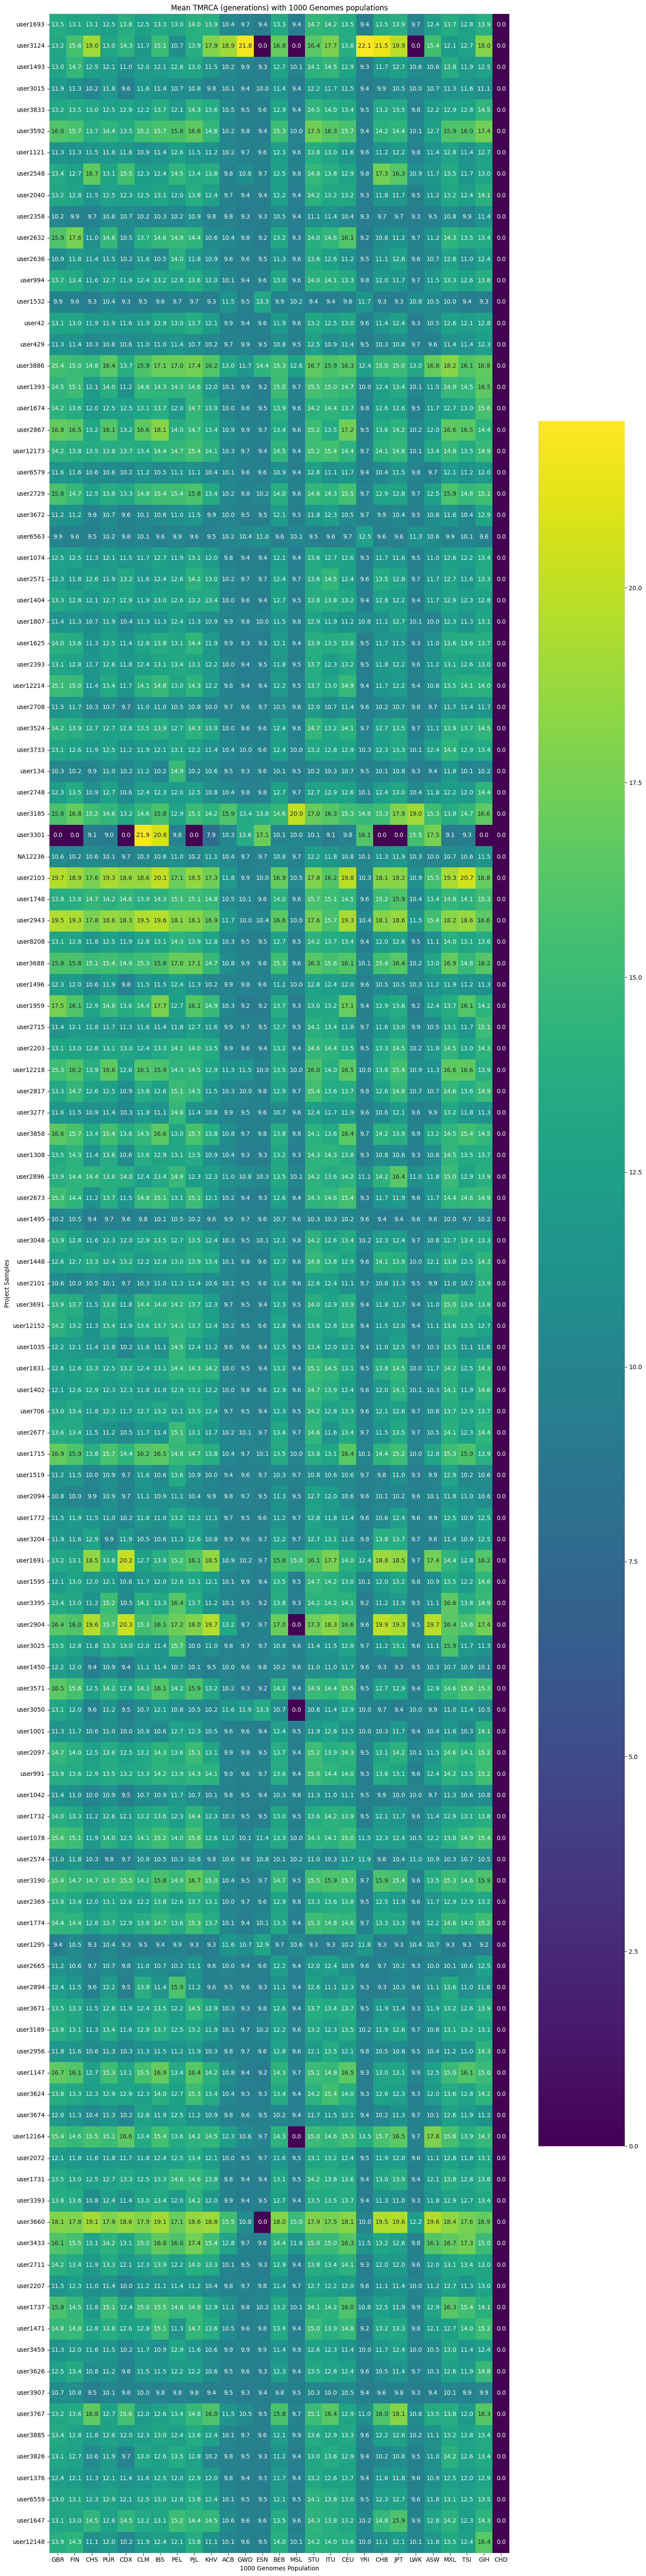

In [28]:
def create_sharing_heatmap(project_samples, sample_df):
    """Create a heatmap of IBD sharing and TMRCA between project samples and populations"""
    # Initialize results matrices with float dtype
    populations = sample_df['Population'].unique()
    sharing_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
    tmrca_gen_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
    tmrca_years_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
    
    # Calculate sharing for each sample-population pair
    for sample in project_samples:
        pop_stats = calculate_sharing_stats(sample, sample_df)
        for _, row in pop_stats.iterrows():
            if pd.notna(row['Population']):
                sharing_matrix.loc[sample, row['Population']] = float(row['total_length_cM'])
                tmrca_gen_matrix.loc[sample, row['Population']] = float(row['mean_tmrca_gen'])
                tmrca_years_matrix.loc[sample, row['Population']] = float(row['mean_tmrca_years'])
    
    # Create single plot for TMRCA generations
    plt.figure(figsize=(15, len(project_samples) * 0.5))
    sns.heatmap(tmrca_gen_matrix, cmap='viridis', annot=True, fmt='.1f')
    plt.title('Mean TMRCA (generations) with 1000 Genomes populations')
    plt.xlabel('1000 Genomes Population')
    plt.ylabel('Project Samples')
    plt.tight_layout()
    plt.show()
    
    return sharing_matrix, tmrca_gen_matrix, tmrca_years_matrix

# Save all three matrices
sharing_matrix, tmrca_gen_matrix, tmrca_years_matrix = create_sharing_heatmap(project_samples, sample_df)

# Save the matrices
sharing_matrix.to_csv(os.path.join(results_directory, 'sharing_matrix.csv'))
tmrca_gen_matrix.to_csv(os.path.join(results_directory, 'tmrca_generations_matrix.csv'))
tmrca_years_matrix.to_csv(os.path.join(results_directory, 'tmrca_years_matrix.csv'))

/tmp/ipykernel_702620/2866388066.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
/tmp/ipykernel_702620/2866388066.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


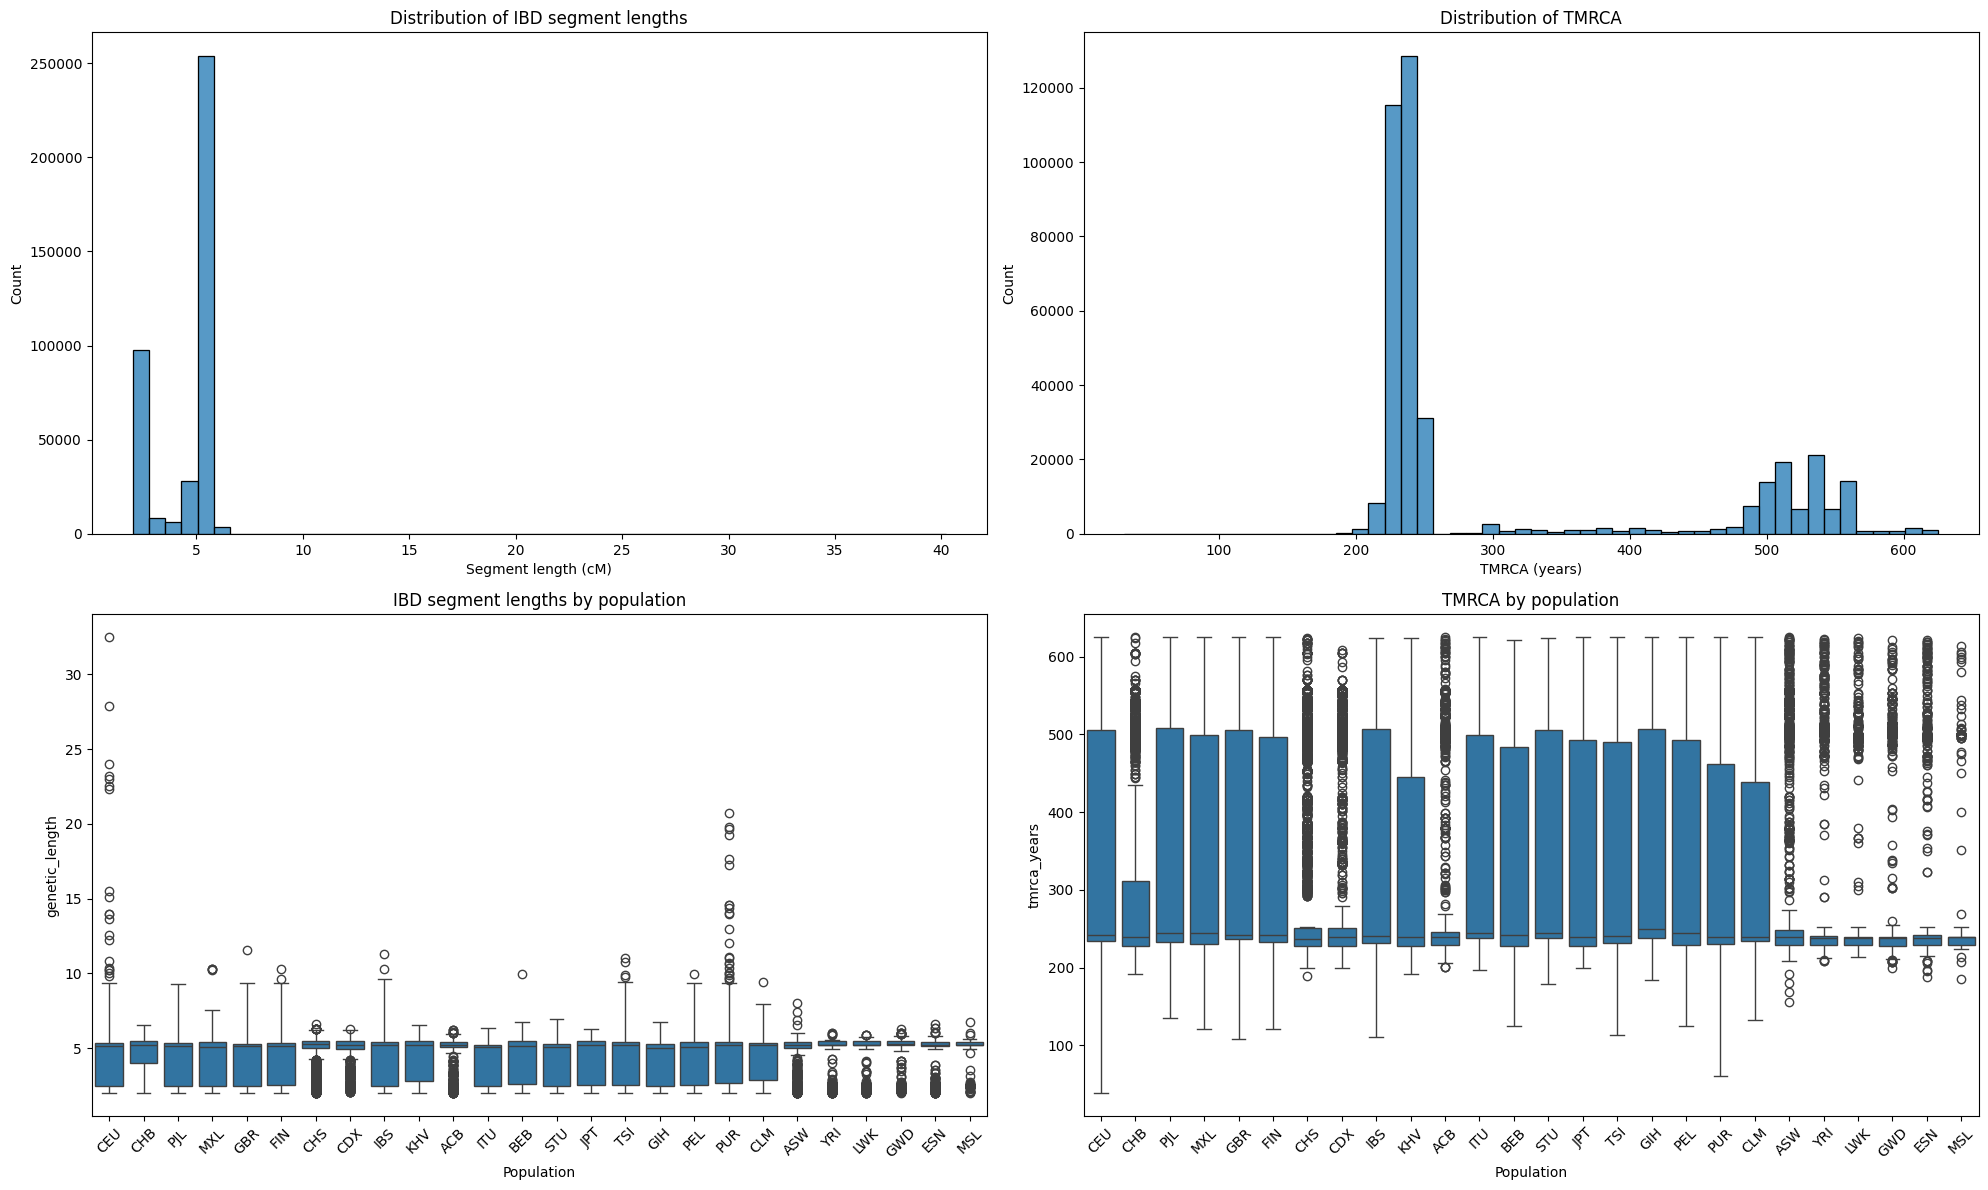

In [29]:
def analyze_segment_distribution(project_samples, sample_df):
    """Analyze the distribution of IBD segment lengths and TMRCA"""
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Get project segments
    project_segments = segments[
        (segments['id1'].isin(project_samples)) | 
        (segments['id2'].isin(project_samples))
    ].copy()
    
    # Calculate TMRCA for segments
    project_segments['tmrca_generations'] = project_segments['genetic_length'].apply(lambda x: 50/x)
    project_segments['tmrca_years'] = project_segments['tmrca_generations'] * 25
    
    # Add population information
    project_segments['other_id'] = np.where(
        project_segments['id1'].isin(project_samples),
        project_segments['id2'],
        project_segments['id1']
    )
    
    merged_segments = pd.merge(
        project_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Plot 1: Segment length distribution
    sns.histplot(data=merged_segments, x='genetic_length', bins=50, ax=ax1)
    ax1.set_title('Distribution of IBD segment lengths')
    ax1.set_xlabel('Segment length (cM)')
    
    # Plot 2: TMRCA distribution
    sns.histplot(data=merged_segments, x='tmrca_years', bins=50, ax=ax2)
    ax2.set_title('Distribution of TMRCA')
    ax2.set_xlabel('TMRCA (years)')
    
    # Plot 3: Box plot of segment lengths by population
    sns.boxplot(data=merged_segments, x='Population', y='genetic_length', ax=ax3)
    ax3.set_title('IBD segment lengths by population')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    # Plot 4: Box plot of TMRCA by population
    sns.boxplot(data=merged_segments, x='Population', y='tmrca_years', ax=ax4)
    ax4.set_title('TMRCA by population')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    return fig, merged_segments

distribution_fig, merged_segments = analyze_segment_distribution(project_samples, sample_df)

In [32]:
def summarize_population_sharing(project_samples, sample_df):
    """Create a summary of IBD sharing and TMRCA with each population"""
    all_stats = []
    
    for sample in project_samples:
        pop_stats = calculate_sharing_stats(sample, sample_df)
        all_stats.append(pop_stats)
    
    # Combine all statistics
    summary_df = pd.concat(all_stats, ignore_index=True)
    
    # Create pivot table for easy viewing
    summary_pivot = pd.pivot_table(
        summary_df, 
        values=['total_length_cM', 'n_segments', 'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years'],
        index='sample_id',
        columns='Population',
        aggfunc='first'
    )
    
    return summary_df, summary_pivot

summary_df, summary_pivot = summarize_population_sharing(project_samples, sample_df)

print("Summary of sharing statistics:")
print(summary_df.head())

print("\nPivot table view:")
print(summary_pivot.head())

# Save the files
summary_df.to_csv(os.path.join(results_directory, 'detailed_summary.csv'))
summary_pivot.to_csv(os.path.join(results_directory, 'pivot_summary.csv'))
distribution_fig.savefig(os.path.join(results_directory, 'segment_distribution.png'), 
                        bbox_inches='tight', 
                        dpi=300)

Summary of sharing statistics:
  sample_id Population                             Population Description  \
0  user1693        ACB                      African Caribbean in Barbados   
1  user1693        ASW                   African Ancestry in Southwest US   
2  user1693        BEB                              Bengali in Bangladesh   
3  user1693        CDX                Chinese Dai in Xishuangbanna, China   
4  user1693        CEU  Utah residents with Northern and Western Europ...   

   n_segments  total_length_cM  mean_length_cM  std_length_cM  mean_tmrca_gen  \
0          80           403.07            5.04           0.79           10.40   
1          42           193.53            4.61           1.35           12.38   
2         134           577.72            4.31           1.39           13.34   
3          89           380.06            4.27           1.49           13.77   
4         473          2018.12            4.27           1.40           13.54   

   min_tmrca_gen  m

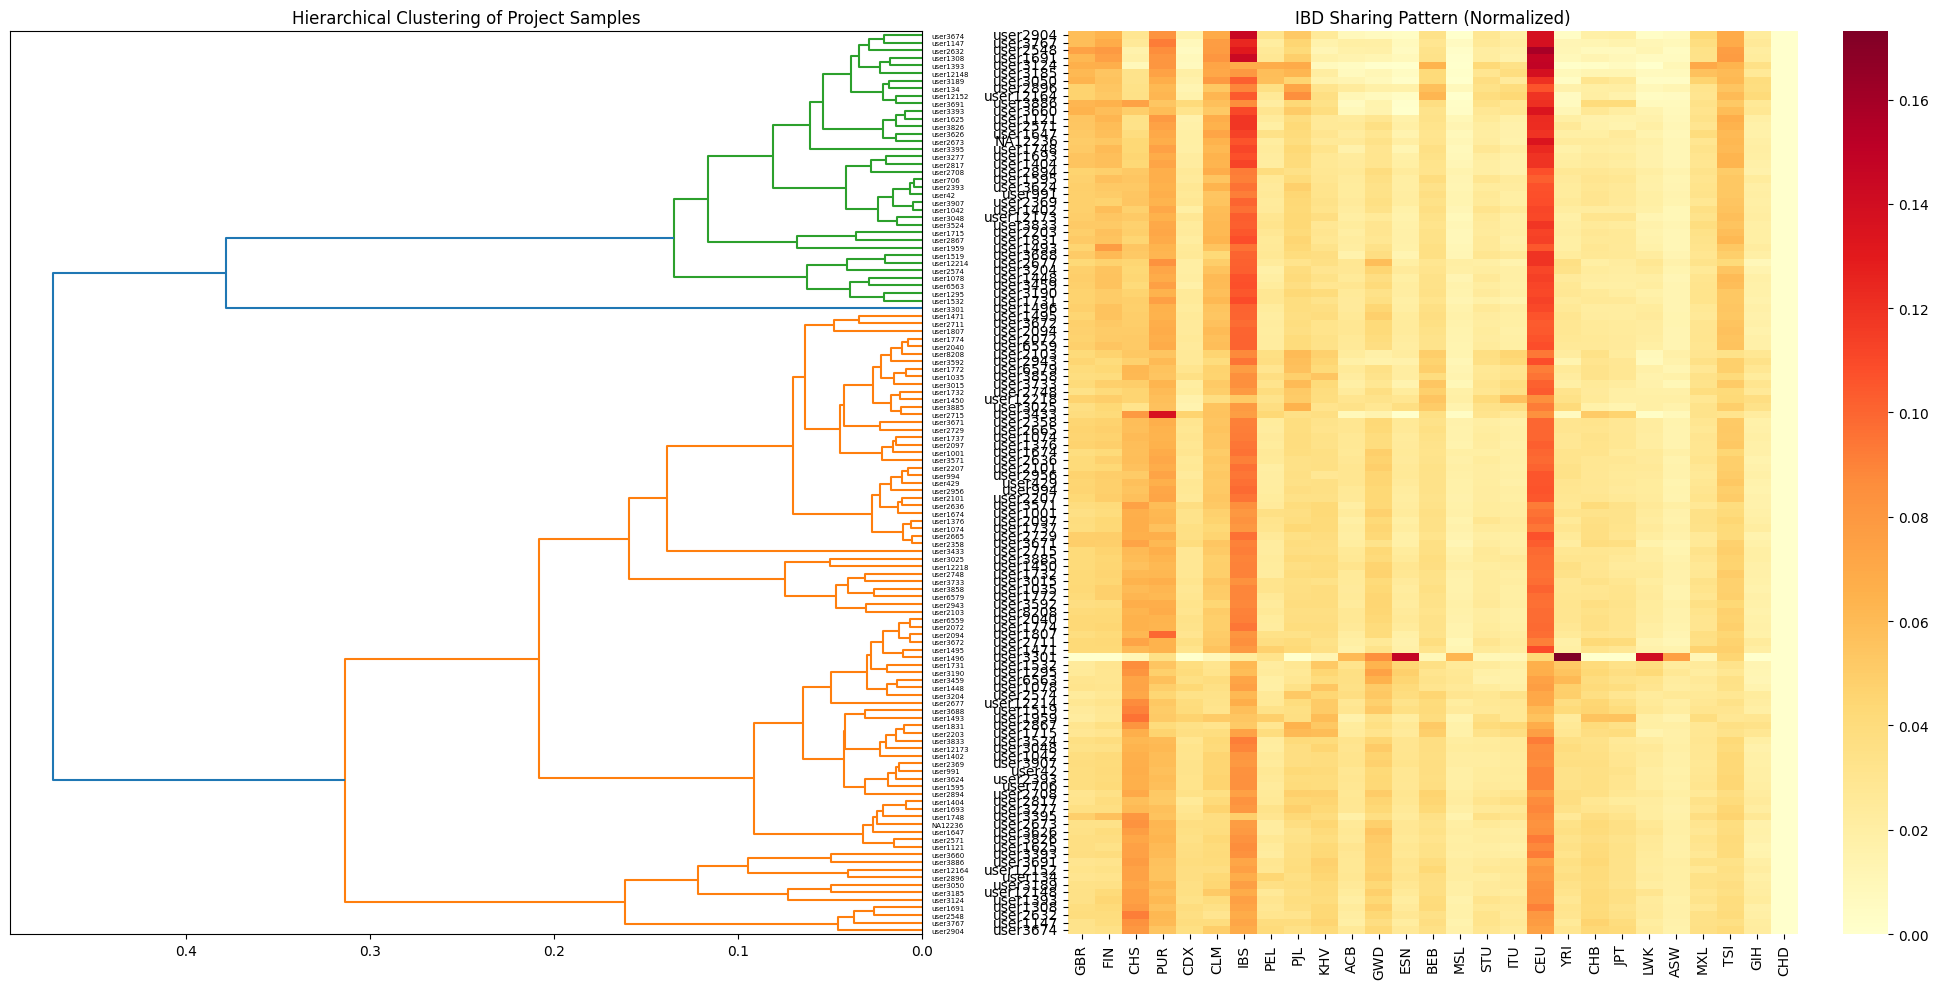

In [33]:
def perform_ibd_clustering(sharing_matrix, sample_df):
    """
    Perform hierarchical clustering on IBD sharing patterns and create visualization
    """
    from scipy.cluster import hierarchy
    from scipy.spatial.distance import pdist
    
    # Normalize the sharing matrix
    normalized_sharing = sharing_matrix.div(sharing_matrix.sum(axis=1), axis=0)
    
    # Calculate distance matrix and perform clustering
    dist_matrix = pdist(normalized_sharing, metric='euclidean')
    linkage_matrix = hierarchy.linkage(dist_matrix, method='ward')
    
    # Create figure with dendrogram and heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot dendrogram
    dendrogram = hierarchy.dendrogram(
        linkage_matrix,
        labels=sharing_matrix.index,
        orientation='left',
        ax=ax1
    )
    ax1.set_title('Hierarchical Clustering of Project Samples')
    
    # Get the ordering of samples from dendrogram
    ordered_samples = [sharing_matrix.index[i] for i in dendrogram['leaves']]
    
    # Plot heatmap with samples ordered by clustering
    sns.heatmap(
        normalized_sharing.loc[ordered_samples],
        cmap='YlOrRd',
        ax=ax2,
        xticklabels=True,
        yticklabels=True
    )
    ax2.set_title('IBD Sharing Pattern (Normalized)')
    plt.tight_layout()

perform_ibd_clustering(sharing_matrix, sample_df)

Number of clusters found: 1


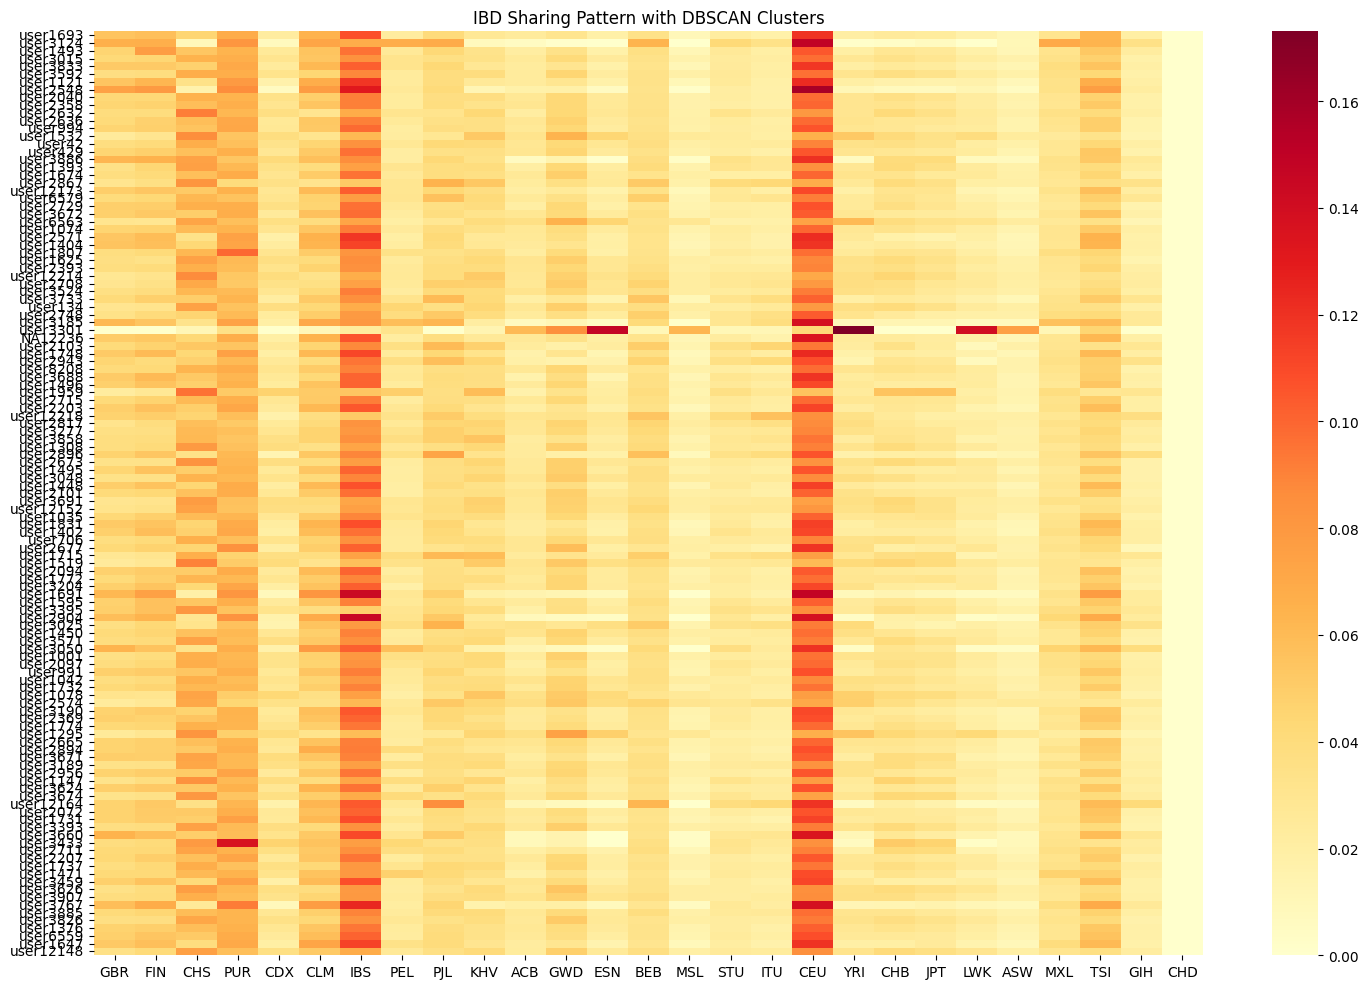

In [34]:
def perform_simple_dbscan(sharing_matrix, results_directory):
    """
    Perform basic DBSCAN clustering on IBD sharing patterns
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import DBSCAN
    import os
    
    # Normalize the data
    normalized_sharing = sharing_matrix.div(sharing_matrix.sum(axis=1), axis=0)
    
    # Scale the data
    X = StandardScaler().fit_transform(normalized_sharing)
    
    # Perform DBSCAN clustering
    db = DBSCAN(eps=0.3, min_samples=3).fit(X)
    labels = db.labels_
    
    # Create cluster labels DataFrame
    cluster_assignments = pd.DataFrame({
        'Sample': sharing_matrix.index,
        'Cluster': [f'Cluster {i}' if i != -1 else 'Noise' for i in labels]
    })
    
    # Create simple plot
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        normalized_sharing,
        cmap='YlOrRd',
        xticklabels=True,
        yticklabels=True
    )
    plt.title('IBD Sharing Pattern with DBSCAN Clusters')
    plt.tight_layout()
    
    # Save results
    cluster_assignments.to_csv(os.path.join(results_directory, 'dbscan_clusters.csv'), index=False)
    plt.savefig(os.path.join(results_directory, 'dbscan_heatmap.png'), bbox_inches='tight', dpi=300)
    
    return cluster_assignments

# Run the analysis
clusters = perform_simple_dbscan(sharing_matrix, results_directory)
print("Number of clusters found:", len(clusters['Cluster'].unique()))

# Save the original matrices
sharing_matrix.to_csv(os.path.join(results_directory, 'sharing_matrix.csv'))
tmrca_gen_matrix.to_csv(os.path.join(results_directory, 'tmrca_generations_matrix.csv'))
tmrca_years_matrix.to_csv(os.path.join(results_directory, 'tmrca_years_matrix.csv'))


Results for user1693:
   Population  Total_IBD_cM  Percent_Genome_IBD
4         CEU      2018.124               59.36
13        IBS      1822.750               53.61
22        PUR      1163.294               34.21
7         CLM      1094.669               32.20
24        TSI      1062.351               31.25
9         FIN       973.242               28.62
10        GBR       929.743               27.35
6         CHS       764.372               22.48
21        PJL       693.497               20.40
2         BEB       577.722               16.99
19        MXL       524.189               15.42
12        GWD       515.340               15.16
16        KHV       461.545               13.57
5         CHB       414.237               12.18
0         ACB       403.066               11.85
15        JPT       396.568               11.66
3         CDX       380.065               11.18
20        PEL       379.127               11.15
23        STU       375.400               11.04
25        YRI    

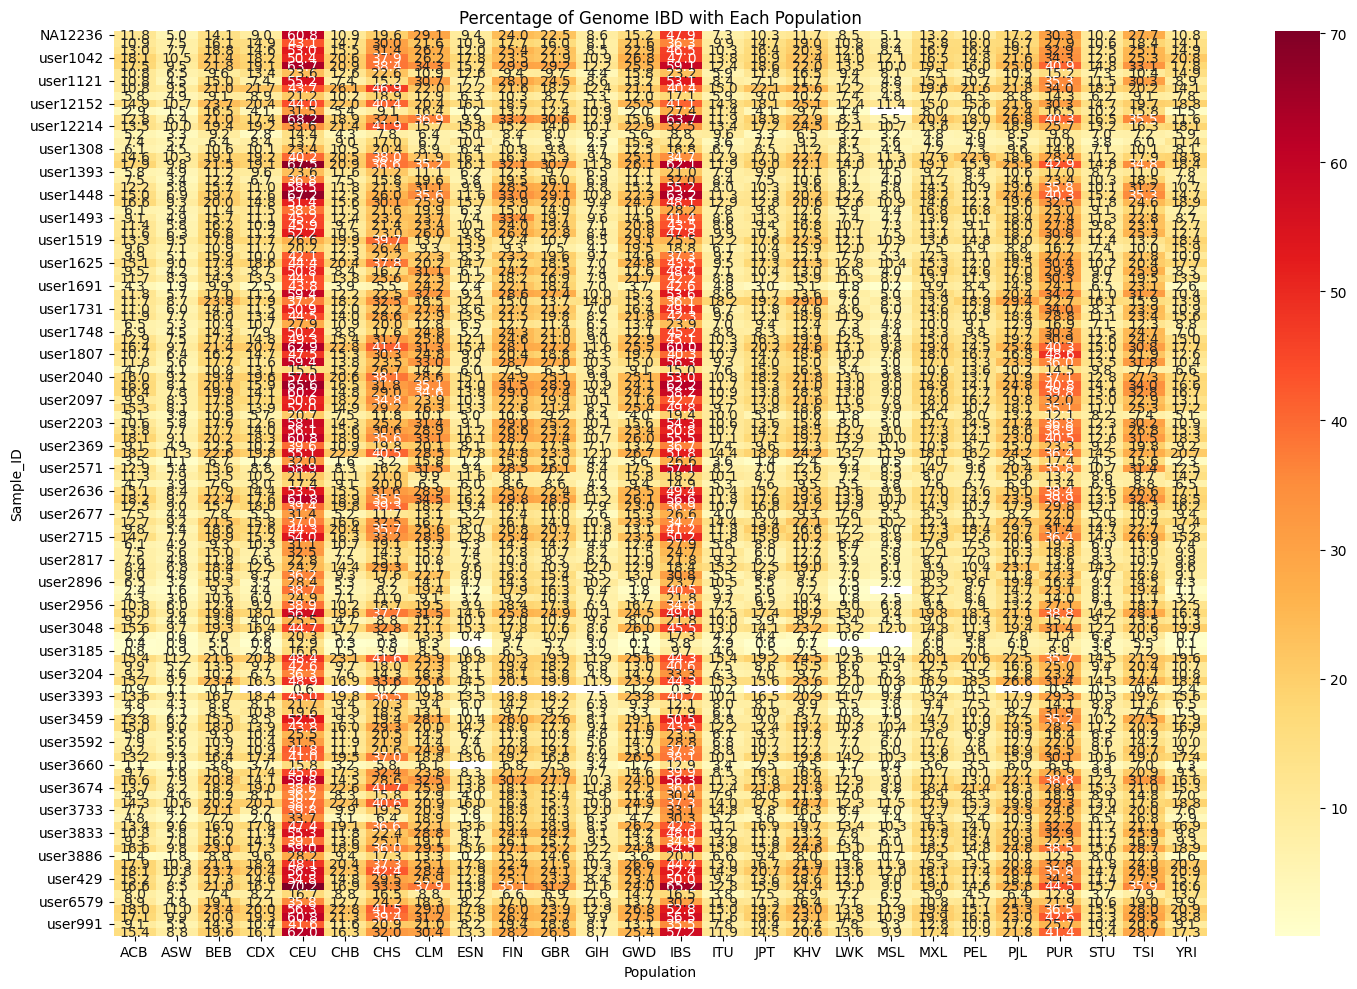

In [35]:
def calculate_ibd_percentages(sample_id, sample_df, total_genome_length=3400):
    """
    Calculate percentage of genome that is IBD with each population and super population
    
    Parameters:
    sample_id: ID of the project sample
    sample_df: 1000 Genomes metadata DataFrame
    total_genome_length: Total genetic length of genome in cM (default 3400)
    """
    # Get IBD segments for this sample
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Get other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Calculate total IBD length by population
    pop_totals = sharing_df.groupby('Population')['genetic_length'].sum()
    pop_percentages = (pop_totals / total_genome_length * 100).round(2)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Population': pop_percentages.index,
        'Total_IBD_cM': pop_totals.values,
        'Percent_Genome_IBD': pop_percentages.values
    })
    
    return summary

# Calculate for all project samples
all_percentages = {}
for sample in project_samples:
    percentages = calculate_ibd_percentages(sample, sample_df)
    all_percentages[sample] = percentages
    
    print(f"\nResults for {sample}:")
    print(percentages.sort_values('Percent_Genome_IBD', ascending=False))

# Combine all results into one DataFrame
combined_results = pd.concat(
    {sample: df for sample, df in all_percentages.items()},
    names=['Sample_ID']
).reset_index()

# Save results
combined_results.to_csv(os.path.join(results_directory, 'ibd_percentages.csv'), index=False)

# Create visualization
plt.figure(figsize=(15, 10))
sns.heatmap(
    combined_results.pivot(index='Sample_ID', columns='Population', values='Percent_Genome_IBD'),
    cmap='YlOrRd',
    annot=True,
    fmt='.1f'
)
plt.title('Percentage of Genome IBD with Each Population')
plt.tight_layout()
plt.show()


Results for user1693:
                Population  Total_IBD_cM  Percent_Genome_IBD
Total_African  All African      2226.100               65.47
3                      GWD       515.340               15.16
0                      ACB       403.066               11.85
6                      YRI       352.218               10.36
2                      ESN       314.212                9.24
4                      LWK       277.725                8.17
1                      ASW       193.528                5.69
5                      MSL       170.011                5.00

Results for user3124:
                Population  Total_IBD_cM  Percent_Genome_IBD
Total_African  All African        52.053                1.53
1                      ASW        30.755                0.90
0                      ACB        14.493                0.43
3                      YRI         4.516                0.13
2                      GWD         2.289                0.07

Results for user1493:
                

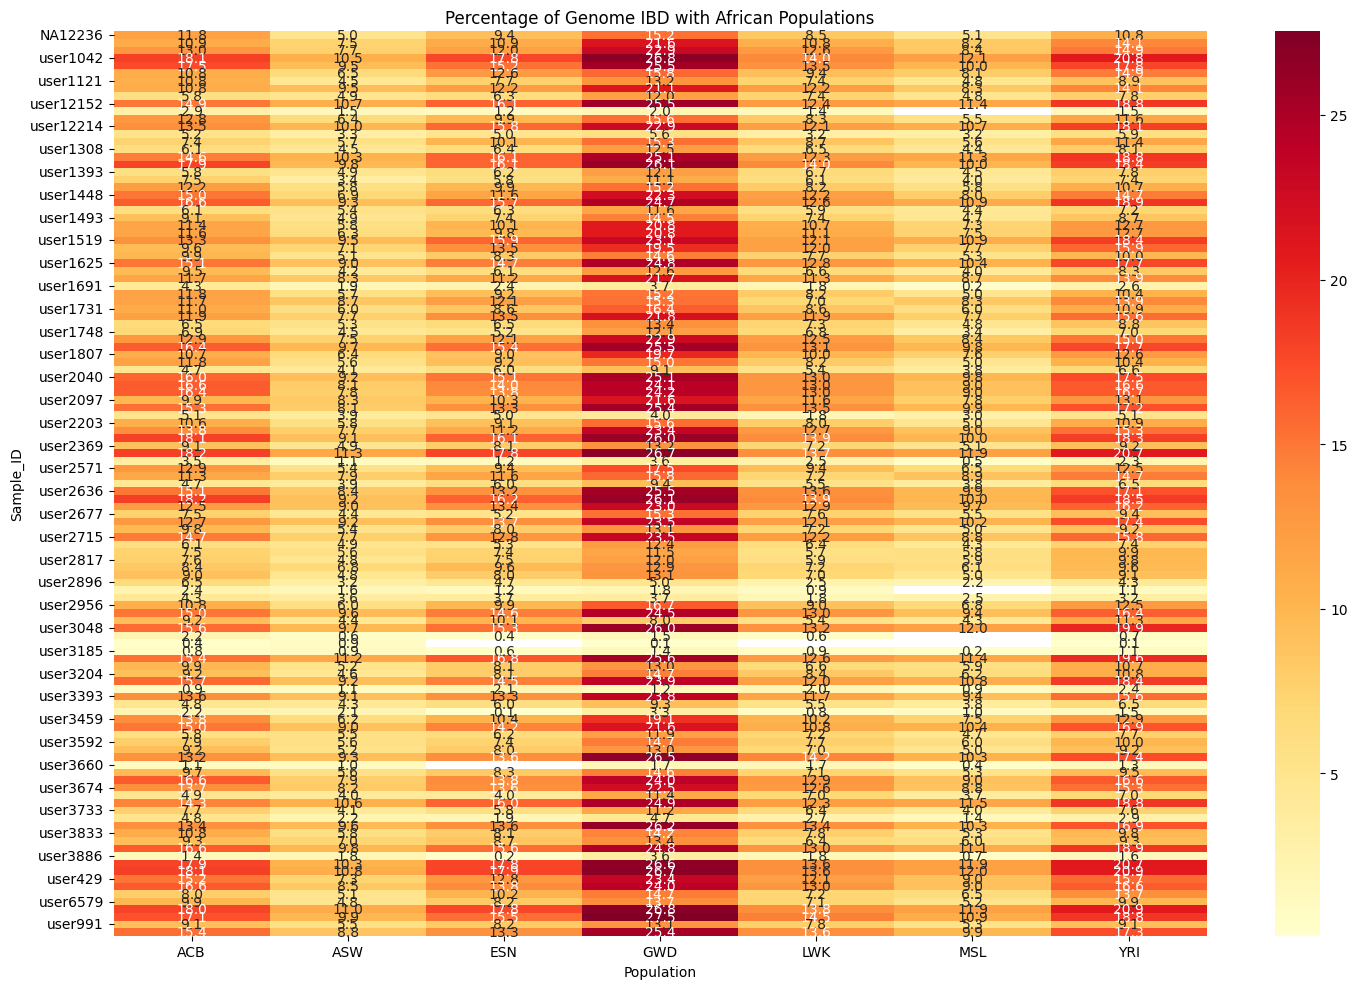

In [39]:
def calculate_african_ibd_percentages(sample_id, sample_df, total_genome_length=3400):
    """
    Calculate percentage of genome that is IBD with African populations
    """
    # Define African populations
    african_pops = ['ESN', 'GWD', 'YRI', 'LWK', 'MSL', 'ACB', 'ASW']  # Add any others I might have missed
    
    # Get IBD segments for this sample
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Get other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Filter for African populations
    african_sharing = sharing_df[sharing_df['Population'].isin(african_pops)]
    
    # Calculate total IBD length by population
    pop_totals = african_sharing.groupby('Population')['genetic_length'].sum()
    pop_percentages = (pop_totals / total_genome_length * 100).round(2)
    
    # Calculate total African IBD
    total_african = pop_totals.sum()
    total_african_percentage = (total_african / total_genome_length * 100).round(2)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Population': pop_percentages.index,
        'Total_IBD_cM': pop_totals.values,
        'Percent_Genome_IBD': pop_percentages.values
    })
    
    # Add total row
    summary.loc['Total_African'] = ['All African', total_african, total_african_percentage]
    
    return summary

# Calculate for all project samples
all_percentages = {}
for sample in project_samples:
    percentages = calculate_african_ibd_percentages(sample, sample_df)
    all_percentages[sample] = percentages
    
    print(f"\nResults for {sample}:")
    print(percentages.sort_values('Percent_Genome_IBD', ascending=False))

# Combine all results
combined_results = pd.concat(
    {sample: df for sample, df in all_percentages.items()},
    names=['Sample_ID']
).reset_index()

# Save results
combined_results.to_csv(os.path.join(results_directory, 'african_ibd_percentages.csv'), index=False)

# Create visualization
plt.figure(figsize=(15, 10))
sns.heatmap(
    combined_results[combined_results['Population'] != 'All African'].pivot(
        index='Sample_ID', 
        columns='Population', 
        values='Percent_Genome_IBD'
    ),
    cmap='YlOrRd',
    annot=True,
    fmt='.1f'
)
plt.title('Percentage of Genome IBD with African Populations')
plt.tight_layout()
plt.show()